In [1]:
from IPython.display import Image
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = load_iris()
X, y = iris.data[:, [1, 2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# hold out validation set
X_itrain, X_val, y_itrain, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in [1, 15, 50]:
  pipe = Pipeline([['sc', StandardScaler()],
                   ['clf', KNeighborsClassifier(n_neighbors=k)]])
  pipe.fit(X_itrain, y_itrain)
  y_pred = pipe.predict(X_val)
  score = accuracy_score(y_val, y_pred)
  print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
  if score > best_score:
    best_k, best_score = k, score
  clfs[k] = pipe

clf = clfs[best_k]
clf.fit(X_train, y_train)
# performance reporting
y_pred = clf.predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' %
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.9375
[15-NN]
Validation accuracy: 0.90625
[50-NN]
Validation accuracy: 0.4375

Test accuracy: 0.89 (n_neighbors=1 selected by the holdout method)


In [4]:
clf = clfs[15]
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=15 selected manually)' % accuracy_score(
    y_test, y_pred))

Test accuracy: 0.93 (n_neighbors=15 selected manually)


In [5]:
from sklearn.model_selection import cross_val_score

iris = load_iris()
X, y = iris.data[:, [1, 2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

In [6]:
best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]:  # experiment different hyperparameter
  pipe = Pipeline([['sc', StandardScaler()],
                   ['clf', KNeighborsClassifier(n_neighbors=k)]])
  pipe.fit(X_train, y_train)
  # K-Fold CV
  scores = cross_val_score(pipe, X_train, y_train, cv=5)
  print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
  if scores.mean() > best_score:
    best_k, best_score = k, scores.mean()
  clfs[k] = pipe

[1-NN]
Validation accuracy: 0.894 [ 0.91304348  0.95454545  0.85        0.85        0.9       ]
[15-NN]
Validation accuracy: 0.914 [ 0.95652174  0.86363636  0.85        0.9         1.        ]
[50-NN]
Validation accuracy: 0.801 [ 0.73913043  0.86363636  0.75        0.75        0.9       ]


In [7]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' %
      (accuracy_score(y_test, y_pred), best_k))

Test accuracy: 0.93 (n_neighbors=15 selected by 5-fold CV)


In [31]:
from sklearn.model_selection import KFold

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
  print('[Outer fold %d/5]' % (i + 1))
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  best_k, best_score = -1, -1
  clfs = {}
  # hyperparameter tuning
  for k in [1, 15, 50]:
    inner_scores = []
    # inner folds
    for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
      X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
      y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]

      pipe = Pipeline([['sc', StandardScaler()],
                       ['clf', KNeighborsClassifier(n_neighbors=k)]])
      pipe.fit(X_itrain, y_itrain)

      y_pred = pipe.predict(X_val)
      inner_scores.append(accuracy_score(y_val, y_pred))
    score_mean = np.mean(inner_scores)
    if best_score < score_mean:
      best_k, best_score = k, score_mean
    clfs[k] = pipe

  # evaluate performance on test fold
  best_clf = clfs[best_k]
  best_clf.fit(X_train, y_train)
  y_pred = best_clf.predict(X_test)
  outer_scores.append(accuracy_score(y_test, y_pred))
  print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x2 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
[  0   1   2   3   7   8   9  10  12  13  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  30  32  33  35  36  37  38  39  40  41  42  43
  44  45  46  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63
  64  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  86  87  88  89  91  93  94  95  96  97  98  99 100 101 103 104 105 106
 108 109 111 112 113 114 115 116 118 120 121 122 123 124 125 126 127 129
 130 131 132 133 134 136 137 138 139 140 141 143 144 145 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 163 166 167 169 170 171 172 174
 175 176 177 178 180 181 182 183 184 185 186 188 190 191 193 194 195 196
 197 198 199 200 202 203 204 205 206 207 208 209 210 211 212 215 216 217
 218 219 220 222 224 225 226 227 228 229 230 231 232 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 251 252 253 254 255 256 258 259
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 278 279
 280 281 282 283 286 287 288 290 2

Test accuracy: 0.85 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
[  0   2   4   5   6   8   9  10  11  12  13  14  16  17  18  19  20  21
  23  24  27  28  29  31  32  33  34  35  36  38  39  40  41  42  44  45
  46  47  48  51  52  53  54  55  56  57  58  59  60  61  62  63  65  66
  67  69  70  73  75  77  78  79  80  81  82  84  85  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 105 106 107 108 110 111 112
 113 114 116 117 118 119 120 122 123 124 125 127 128 130 131 132 134 135
 137 138 139 140 142 145 146 147 148 149 150 151 152 154 157 158 159 160
 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 177 179 180
 181 182 183 184 185 186 187 188 189 191 192 193 194 197 198 199 200 201
 202 204 205 206 207 208 210 211 212 213 214 217 218 219 220 221 222 223
 224 225 227 228 229 230 231 232 233 234 236 238 240 242 244 245 246 247
 248 249 250 251 253 256 257 258 259 260 261 262 263 267 268 269 270 271
 272 273 274 275 277 278 283 284 285 286 

In [33]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
  print('[Outer fold %d/5]' % (i + 1))
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
  # hyperparameter tuning by grid search CV
  param_grid = {'clf__n_neighbors': [1, 15, 50]}
  gs = GridSearchCV(
      estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=inner_cv)
  gs.fit(X_train, y_train)
  best_clf = gs.best_estimator_
  best_clf.fit(X_train, y_train)
  outer_scores.append(best_clf.score(X_test, y_test))
  print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
0 [  0   1   2   3   7   8   9  10  12  13  14  15  16  18  19  20  21  22
  23  24  25  26  27  28  30  32  33  35  36  37  38  39  40  41  42  43
  44  45  46  48  49  50  51  52  53  54  55  56  57  58  59  60  61  63
  64  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  86  87  88  89  91  93  94  95  96  97  98  99 100 101 103 104 105 106
 108 109 111 112 113 114 115 116 118 120 121 122 123 124 125 126 127 129
 130 131 132 133 134 136 137 138 139 140 141 143 144 145 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 163 166 167 169 170 171 172 174
 175 176 177 178 180 181 182 183 184 185 186 188 190 191 193 194 195 196
 197 198 199 200 202 203 204 205 206 207 208 209 210 211 212 215 216 217
 218 219 220 222 224 225 226 227 228 229 230 231 232 234 235 236 237 238
 239 240 241 242 243 244 245 246 247 248 251 252 253 254 255 256 258 259
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 278 279
 280 281 282 283 286 287 288 290

Test accuracy: 0.85 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
4 [  0   2   4   5   6   8   9  10  11  12  13  14  16  17  18  19  20  21
  23  24  27  28  29  31  32  33  34  35  36  38  39  40  41  42  44  45
  46  47  48  51  52  53  54  55  56  57  58  59  60  61  62  63  65  66
  67  69  70  73  75  77  78  79  80  81  82  84  85  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 105 106 107 108 110 111 112
 113 114 116 117 118 119 120 122 123 124 125 127 128 130 131 132 134 135
 137 138 139 140 142 145 146 147 148 149 150 151 152 154 157 158 159 160
 161 162 163 164 165 167 168 169 170 171 172 173 174 175 176 177 179 180
 181 182 183 184 185 186 187 188 189 191 192 193 194 197 198 199 200 201
 202 204 205 206 207 208 210 211 212 213 214 217 218 219 220 221 222 223
 224 225 227 228 229 230 231 232 233 234 236 238 240 242 244 245 246 247
 248 249 250 251 253 256 257 258 259 260 261 262 263 267 268 269 270 271
 272 273 274 275 277 278 283 284 285 28

In [11]:
def gen_data(num_data, sigma):
  x = 2 * np.pi * (np.random.rand(num_data) - 0.5)
  y = np.sin(x) + np.random.normal(0, sigma, num_data)
  return (x, y)

In [12]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sigma = 1
n_range = range(10, 50, 2)
k_range = [5, 10]

poly = PolynomialFeatures(degree=2)
X = np.array([])
y = np.array([])
cv5_mean = []
cv5_std = []
cv10_mean = []
cv10_std = []
exp_mean = []
for n in n_range:
  # compute the bias and variance of cv5
    mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])

        cv5 = KFold(n_splits=5, random_state=1)
    for i, (train, test) in enumerate(cv5.split(X, y)):
        lr = LinearRegression()
        lr.fit(X[train], y[train])
        y_test_pred = lr.predict(X[test])
        mse_test.append(mean_squared_error(y[test], y_test_pred))

    cv5_mean.append(np.mean(mse_test))
    cv5_std.append(np.std(mse_test))

  # compute the bias and variance of cv10
  mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])

        cv10 = KFold(n_splits=10, random_state=1)
    for i, (train, test) in enumerate(cv10.split(X, y)):
        lr = LinearRegression()
        lr.fit(X[train], y[train])
        y_test_pred = lr.predict(X[test])
        mse_test.append(mean_squared_error(y[test], y_test_pred))

    cv10_mean.append(np.mean(mse_test))
    cv10_std.append(np.std(mse_test))

  # compute the expected generalization error of f_N
  mse_test = []
    for i in range(500):
        x, y = gen_data(n, sigma)
        X = poly.fit_transform(x[:, np.newaxis])
        lr = LinearRegression()
        lr.fit(X, y)
        x_test, y_test = gen_data(100, sigma)
        X_test = poly.transform(x_test[:, np.newaxis])
        y_test_pred = lr.predict(X_test)
        mse_test.append(mean_squared_error(y_test, y_test_pred))
    exp_mean.append(np.mean(mse_test))

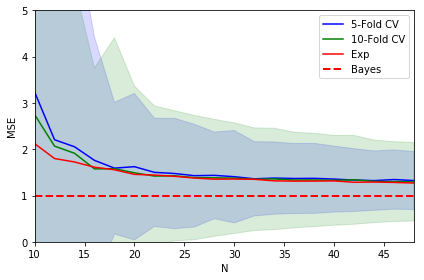

In [13]:
plt.plot(n_range, cv5_mean, markersize=5, label='5-Fold CV', color='blue')
plt.fill_between(
    n_range,
    np.add(cv5_mean, cv5_std),
    np.subtract(cv5_mean, cv5_std),
    alpha=0.15,
    color='blue')

plt.plot(n_range, cv10_mean, markersize=5, label='10-Fold CV', color='green')
plt.fill_between(
    n_range,
    np.add(cv10_mean, cv10_std),
    np.subtract(cv10_mean, cv10_std),
    alpha=0.15,
    color='green')

plt.plot(n_range, exp_mean, markersize=5, label='Exp', color='red')

plt.hlines(
    y=sigma,
    xmin=10,
    xmax=48,
    label='Bayes',
    color='red',
    linewidth=2,
    linestyle='--')

plt.legend(loc='upper right')
plt.xlim([10, 48])
plt.ylim([0, 5])
plt.xlabel('N')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('./output/fig-cv-fold.png', dpi=300)
plt.show()

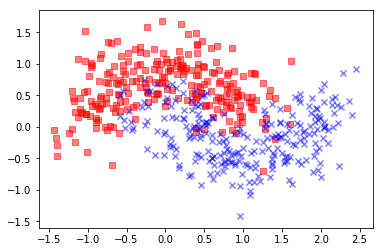

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)

plt.scatter(
    X[y == 0, 0], X[y == 0, 1], label='Class 0', c='r', marker='s', alpha=0.5)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Class 1', c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', KNeighborsClassifier(n_neighbors=5)]])

In [24]:
from sklearn.model_selection import cross_val_score

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
print(X_train)
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
  scores = cross_val_score(
      estimator=pipe, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
[[ -1.16069702e+00   2.38581681e-01]
 [  6.00989343e-01  -5.03736697e-01]
 [  1.26407987e+00   2.65228644e-01]
 [ -5.44641147e-01   7.17198020e-01]
 [ -6.16698741e-02   1.00154053e+00]
 [  1.47885723e+00  -1.67548959e-01]
 [  1.16390993e+00  -2.22875983e-01]
 [  4.13705952e-01   1.94928448e-01]
 [  1.63046110e+00  -9.15581481e-01]
 [  1.96464477e+00   1.14057017e-01]
 [ -1.10001169e+00   4.50503137e-01]
 [ -8.11329173e-01   3.56868828e-01]
 [  1.17260396e+00  -5.78900509e-01]
 [  1.78436035e+00  -6.01267010e-02]
 [  6.49128023e-02  -3.19200600e-01]
 [  1.09885467e+00   3.10004940e-01]
 [  1.32014324e-01   6.20298135e-01]
 [  1.53665738e+00  -1.07666956e-01]
 [ -5.42544819e-01   9.72615071e-01]
 [  9.19156074e-02  -3.00917851e-01]
 [  3.78469964e-01   5.21583233e-01]
 [  1.37297478e+00  -6.03064130e-01]
 [ -1.20252537e+00   5.61676523e-01]
 [  1.24104996e+00   7.59867231e-02]
 [  2.05732644e+00   8.29503667e-03]
 [  4.00859722e-01   1.16376727e+00]
 [  4.50784057e-01  -1.77

In [16]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(
    itertools.permutations(range(0, 3))):  # try some weight combination
  clf = VotingClassifier(
      estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)],
      voting='soft',
      weights=[a, b, c])
  scores = cross_val_score(
      estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('%s: %.3f (+/- %.3f)' % ((a, b, c), scores.mean(), scores.std()))
  if best_score < scores.mean():
    best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.959 (+/- 0.021)
(0, 2, 1): 0.960 (+/- 0.019)
(1, 0, 2): 0.958 (+/- 0.023)
(1, 2, 0): 0.944 (+/- 0.025)
(2, 0, 1): 0.948 (+/- 0.023)
(2, 1, 0): 0.939 (+/- 0.025)

Best (0, 2, 1): 0.960


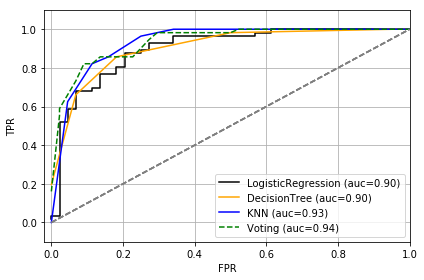

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels,
                               colors, linestyles):
  # assume positive class is at dimension 2
  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)

  plt.plot(
      fpr,
      tpr,
      color=clr,
      linestyle=ls,
      label='%s (auc=%0.2f)' % (label, roc_auc))
  plt.legend(loc='lower right')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlim([-0.02, 1])
  plt.ylim([-0.1, 1.1])
  plt.grid()
  plt.xlabel('FPR')
  plt.ylabel('TPR')

plt.grid()
plt.tight_layout()
plt.savefig('./output/fig-vote-roc.png', dpi=300)
plt.show()

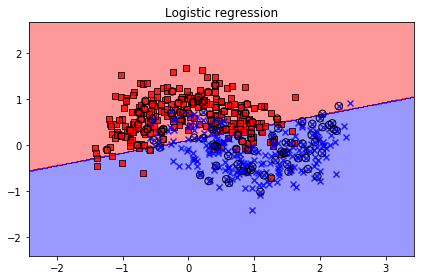

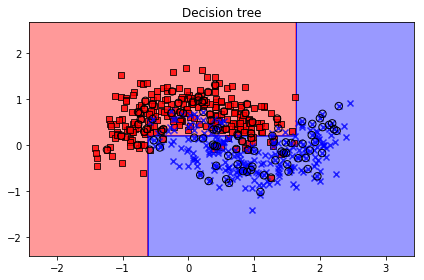

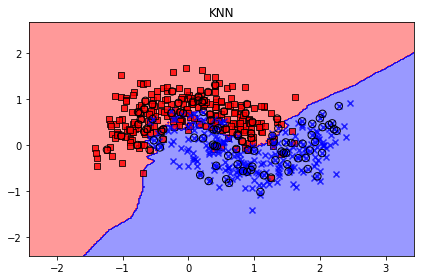

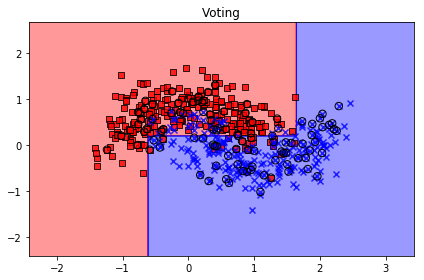

In [18]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe1,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe2,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe3,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=best_vt,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/fig-voting-boundary.png', dpi=300)
plt.show()

In [20]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(
    criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(
    base_estimator=tree,
    n_estimators=500,
    max_samples=0.7,
    bootstrap=True,
    max_features=1.0,
    bootstrap_features=False,
    n_jobs=1,
    random_state=1)

In [21]:
from sklearn.metrics import accuracy_score

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' %
      (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('[Bagging] auc-train = %.3f, auc-test = %.3f' % (bag_train, bag_test))

[DecisionTree] accuracy-train = 1.000, accuracy-test = 0.840
[Bagging] auc-train = 0.993, auc-test = 0.860


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] accuracy-train = %.3f, accuracy-test = %.3f' %
      (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] accuracy-train = %.3f, accuracy-test = %.3f' % (ada_train,
                                                                  ada_test))

[DecisionTree] accuracy-train = 0.838, accuracy-test = 0.710
[AdaBoost] accuracy-train = 1.000, accuracy-test = 0.870


In [30]:
from sklearn.metrics import scorer
y_type = scorer.type_of_target(y_train)
print(y_type)

binary


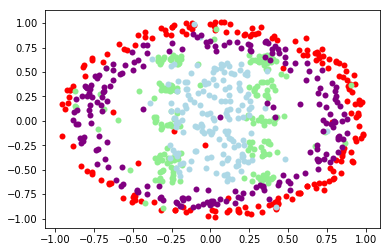

In [34]:
import csv

file = open('train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X_train = X.astype(np.float)
y_train = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

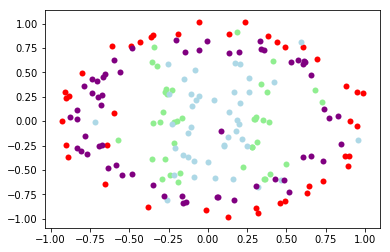

In [35]:
file = open('test.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
  i += 1
  X = np.vstack((X, np.array(row[0:2])))
  y = np.append(y, y_mapping[row[2]])
X_test = X.astype(np.float)
y_test = y.astype(np.float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

In [36]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_train, y_train)):
    print('[Outer fold %d/5]' % (i + 1))
    X_vtrain, X_vtest = X_train[train_idx], X_train[test_idx]
    y_vtrain, y_vtest = y_train[train_idx], y_train[test_idx]

    pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
    # hyperparameter tuning by grid search CV
    param_grid = {'clf__n_neighbors': [1, 15, 50]}
    gs = GridSearchCV(
      estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=inner_cv)
    gs.fit(X_vtrain, y_vtrain)
    best_clf = gs.best_estimator_
    best_clf.fit(X_vtrain, y_vtrain)
    outer_scores.append(best_clf.score(X_vtest, y_vtest))
    print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.89 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.94 (n_neighbors=50 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.81 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.88 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.88 (n_neighbors=1 selected by inner 10-fold CV)

Test accuracy: 0.88 (5x10 nested CV)
